In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm
from IPython.display import clear_output
from collections import deque

In [2]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

In [3]:
#discretize the spaces
discrete_factor = 50
x_discrete = np.linspace(-1.2, 0.6, discrete_factor)
v_discrete = np.linspace(-0.07, 0.07, discrete_factor)

def cont_to_discrete(state):
    x, v = state
    x_discrete_idx = np.digitize(x, x_discrete)
    v_discrete_idx = np.digitize(v, v_discrete)
    return (x_discrete_idx, v_discrete_idx)

In [17]:
from scipy.special import softmax
def choose_action_softmax(Q, state, tau):
    return np.random.choice(Q.shape[-1], p = softmax(Q[state]/tau))

In [31]:
def q_learning(Q, env, max_episodes, max_t, gamma, alpha, tau_0, tau_decay):
    rewards = np.zeros(max_episodes)
    #Dictionary for storing number of times a state is visited
    #visit_count = dict()

    tau = tau_0
    #c = 1
    #Store mean of last 100 scores
    last_100_mean = 0
    for episode in range(1, max_episodes+1):
        state, _ = env.reset()
        state = cont_to_discrete(state)
        score = 0
        for t in range(max_t):
            action = choose_action_softmax(Q, state, tau)
            next_state, base_reward, done, _ , _ = env.step(action)
            reward = base_reward + next_state[0] + next_state[1]*10
            next_state = cont_to_discrete(next_state)

         #   if next_state in visit_count:
         #       visit_count[next_state[0]] += 1
          #  else:
         #       visit_count[next_state[0]] = 1
            #Increase reward if next state is not visited or visited less often
          #  reward = base_reward + c/(visit_count[next_state[0]]+1)


            Q[state + (action,)] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state + (action,)])
            state = next_state
            score += base_reward
            if done:
                break

        rewards[episode-1] = score

        if episode == 1:
            last_100_mean = score
        elif episode <= 100:
            last_100_mean = (last_100_mean * (episode-1) + score) / episode
        else:
            last_100_mean += (score - rewards[episode-100]) / 100

        tau *= tau_decay
        #c *= 0.9995

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, last_100_mean), end="")

        #if episode % 5000 == 0:
        #print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, last_100_mean))
        if last_100_mean>-110.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, last_100_mean))
           rewards[episode:] = -110.0
           return rewards
    return rewards

In [34]:
max_episodes=30000
max_t=200
gamma = 0.99
alpha = 0.1
tau_0 = 1
tau_decay_values = [0.999, 0.9993, 0.9995, 0.9997, 0.9999]
rewards = dict()
regrets = dict()
for tau_decay in tau_decay_values:
    print("\ntau_decay = ", tau_decay)
    reward_sum = np.zeros(max_episodes)
    for i in range(5):
        print("\nRun: ", i+1)
        Q = np.random.uniform(low=0, high=1, size=[discrete_factor+1, discrete_factor+1, no_of_actions])
        reward_sum += q_learning(Q, env, max_episodes, max_t, gamma, alpha, tau_0, tau_decay)
    rewards[tau_decay] = reward_sum/5

    total_regret = -110*len(rewards[tau_decay]) - np.sum(rewards[tau_decay])
    regrets[tau_decay] = total_regret
    print('Total regret for tau = {} : {}'.format(tau_decay, total_regret))


tau_decay =  0.999

Run:  1
Episode 30000	Average Score: -118.40
Run:  2
Episode 30000	Average Score: -117.14
Run:  3
Episode 30000	Average Score: -129.50
Run:  4
Episode 30000	Average Score: -132.94
Run:  5
Episode 30000	Average Score: -127.49Total regret for tau = 0.999 : 1510009.2000000002

tau_decay =  0.9993

Run:  1
Episode 30000	Average Score: -134.61
Run:  2
Episode 30000	Average Score: -120.41
Run:  3
Episode 30000	Average Score: -120.43
Run:  4
Episode 30000	Average Score: -139.48
Run:  5
Episode 30000	Average Score: -127.86Total regret for tau = 0.9993 : 1530901.2000000002

tau_decay =  0.9995

Run:  1
Episode 30000	Average Score: -127.14
Run:  2
Episode 30000	Average Score: -129.62
Run:  3
Episode 30000	Average Score: -133.35
Run:  4
Episode 30000	Average Score: -124.91
Run:  5
Episode 30000	Average Score: -122.75Total regret for tau = 0.9995 : 1562458.5999999996

tau_decay =  0.9997

Run:  1
Episode 30000	Average Score: -129.85
Run:  2
Episode 30000	Average Score: -129.51

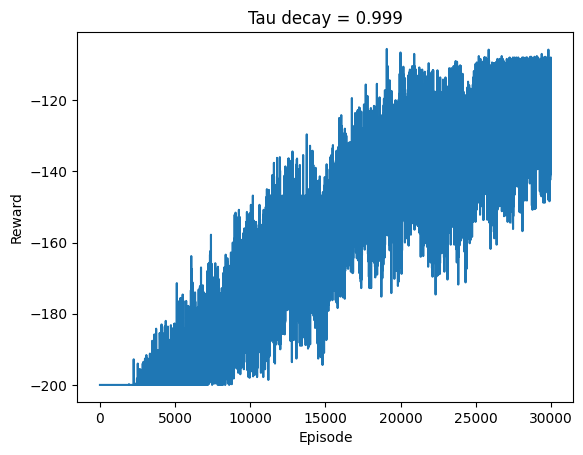

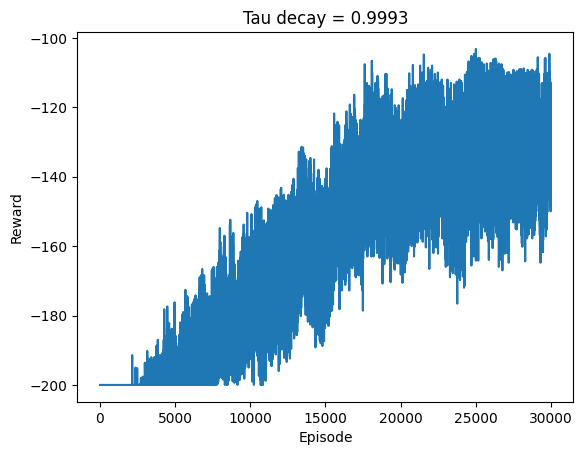

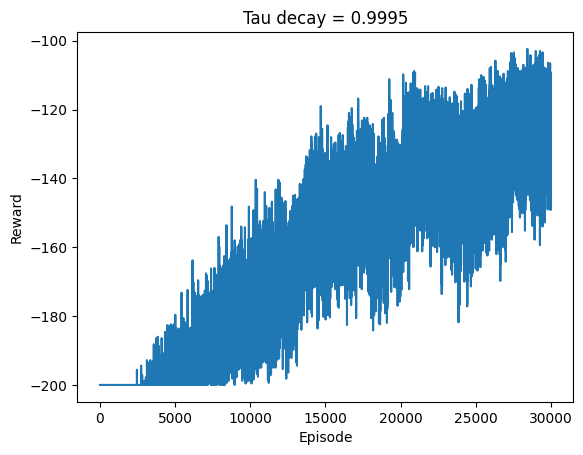

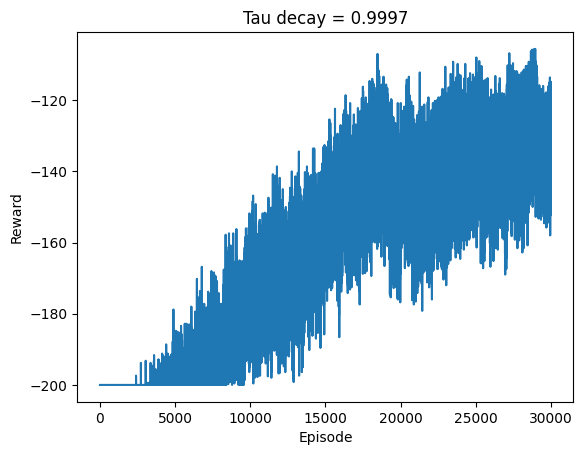

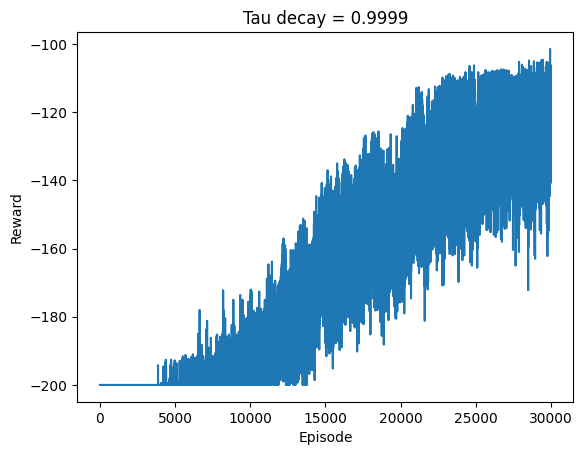

In [35]:
for tau_decay in tau_decay_values:
    plt.plot(range(1, len(rewards[tau_decay])+1), rewards[tau_decay])
    plt.title('Tau decay = ' + str(tau_decay))
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

In [41]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[n:] = ret[n:] / n
    ret[:n] = ret[:n]/np.arange(1, n+1, 1)
    return ret

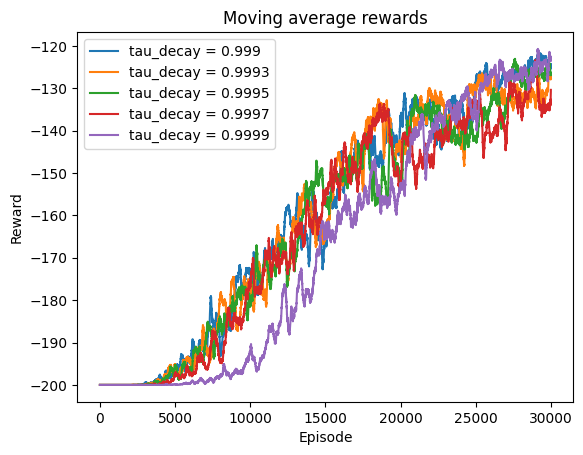

In [42]:
for tau_decay in tau_decay_values:
    plt.plot(range(1, len(rewards[tau_decay])+1), moving_average(rewards[tau_decay], 100), label='tau_decay = ' + str(tau_decay))
plt.title('Moving average rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()